In [1]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import keras
from keras.preprocessing import image
from keras import Model
import time
import pandas as pd

from utils import *

In [2]:
img = Image.open('test.jpg')
img = np.asarray(img)

Evalut the model by CPU in TFLite

In [3]:
tflite_model = tf.lite.Interpreter(model_path='./model/newer/MobileNet.tflite')
tflite_model.allocate_tensors()

cpu_tf_quant_image = np.expand_dims(img, axis=0).astype(np.float32)

input_layer = tflite_model.get_input_details()[0]['index']
output_layer = tflite_model.get_output_details()[0]['index']

tflite_model.set_tensor(input_layer, cpu_tf_quant_image)

In [8]:
begin = time.time_ns()
tflite_model.invoke()
end = time.time_ns()

pred = tflite_model.get_tensor(output_layer)

print((end - begin) / 1000000000)

3.5432407


Evalut the model by CPU in original

In [9]:
begin = time.time_ns()
model_invoke(img)
end = time.time_ns()

print((end - begin) / 1000000000)


1885.8606842


In [2]:
import tensorflow_model_optimization as tfmot
import keras
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Evalution of the model by GPU in INT8

In [4]:
import tensorflow_model_optimization as tfmot

with tfmot.quantization.keras.quantize_scope():
    gpu_INT8_model = keras.models.load_model('model/newer/MobileNet_quantized.h5')
    gpu_INT8_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
quantize_layer (QuantizeLaye (None, 224, 224, 3)       3         
_________________________________________________________________
quant_conv2d (QuantizeWrappe (None, 112, 112, 32)      961       
_________________________________________________________________
quant_batch_normalization (Q (None, 112, 112, 32)      129       
_________________________________________________________________
quant_re_lu (QuantizeWrapper (None, 112, 112, 32)      3         
_________________________________________________________________
quant_depthwise_conv2d (Quan (None, 112, 112, 32)      323       
_________________________________________________________________
quant_batch_normalization_1  (None, 112, 112, 32)      129       
_________________________________________________________________
quant_re_lu_1 (QuantizeWrapp (None, 112, 112, 32)      3

In [6]:
test_image = np.expand_dims(img, axis=0).astype(np.float32)

In [44]:

begin = time.time_ns() / 1000
gpu_INT8_model.predict(test_image)
end = time.time_ns() / 1000
print(end - begin, end='\r')

In [40]:
with tfmot.quantization.keras.quantize_scope():
    gpu_FLOAT_model = keras.models.load_model('model/newer/MobileNet.h5')

In [45]:
begin = time.time_ns() / 1000
gpu_FLOAT_model.predict(test_image)
end = time.time_ns() / 1000
print(end - begin, end='\r')


In [5]:
trainDataFrame = pd.read_csv('F:/GTSRB_R/GTSRB_DATA_SET/Train.csv')
testDataFrame = pd.read_csv('F:/GTSRB_R/GTSRB_DATA_SET/Test.csv')

trainDataFrame['ClassId'] = trainDataFrame['ClassId'].astype(str)
testDataFrame['ClassId'] = testDataFrame['ClassId'].astype(str)

for i in range(0, len(trainDataFrame['ClassId'])):
    if len(trainDataFrame['ClassId'][i]) == 1:
        trainDataFrame['ClassId'][i] = '0' + trainDataFrame['ClassId'][i]
for i in range(0, len(testDataFrame['ClassId'])):
    if len(testDataFrame['ClassId'][i]) == 1:
        testDataFrame['ClassId'][i] = '0' + testDataFrame['ClassId'][i]

testDataGen = image.ImageDataGenerator(

)

testDataGenerator = testDataGen.flow_from_dataframe(
    dataframe=testDataFrame,
    directory='F:/GTSRB_R/GTSRB_DATA_SET/',
    x_col='Path',
    y_col='ClassId',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)
# print(trainDataFrame['ClassId'][20], trainDataFrame['Path'][20])
# img = Image.open('F:/GTSRB_R/GTSRB_DATA_SET/' + trainDataFrame['Path'][20])
# plt.imshow(img)

Found 12630 validated image filenames belonging to 43 classes.


In [16]:
model = keras.models.load_model('model/fianl/MobileNet_98.39.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 112, 112, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 32)      128       
_________________________________________________________________
re_lu (ReLU)                 (None, 112, 112, 32)      0         
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 112, 112, 32)      320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 32)      128       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      2

In [21]:
model.evaluate(testDataGenerator, verbose=1)

790/790 [==============================] - 37s 46ms/step - loss: 0.0602 - accuracy: 0.9839

[0.06015479192137718, 0.9839271306991577]

In [17]:
pred = model.predict(testDataGenerator)

In [18]:
y = np.argmax(pred, axis=1)

In [12]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [19]:
mat = confusion_matrix(testDataGenerator.classes, y)
mat_norm = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]
mat_norm= np.around(mat_norm, decimals=2)

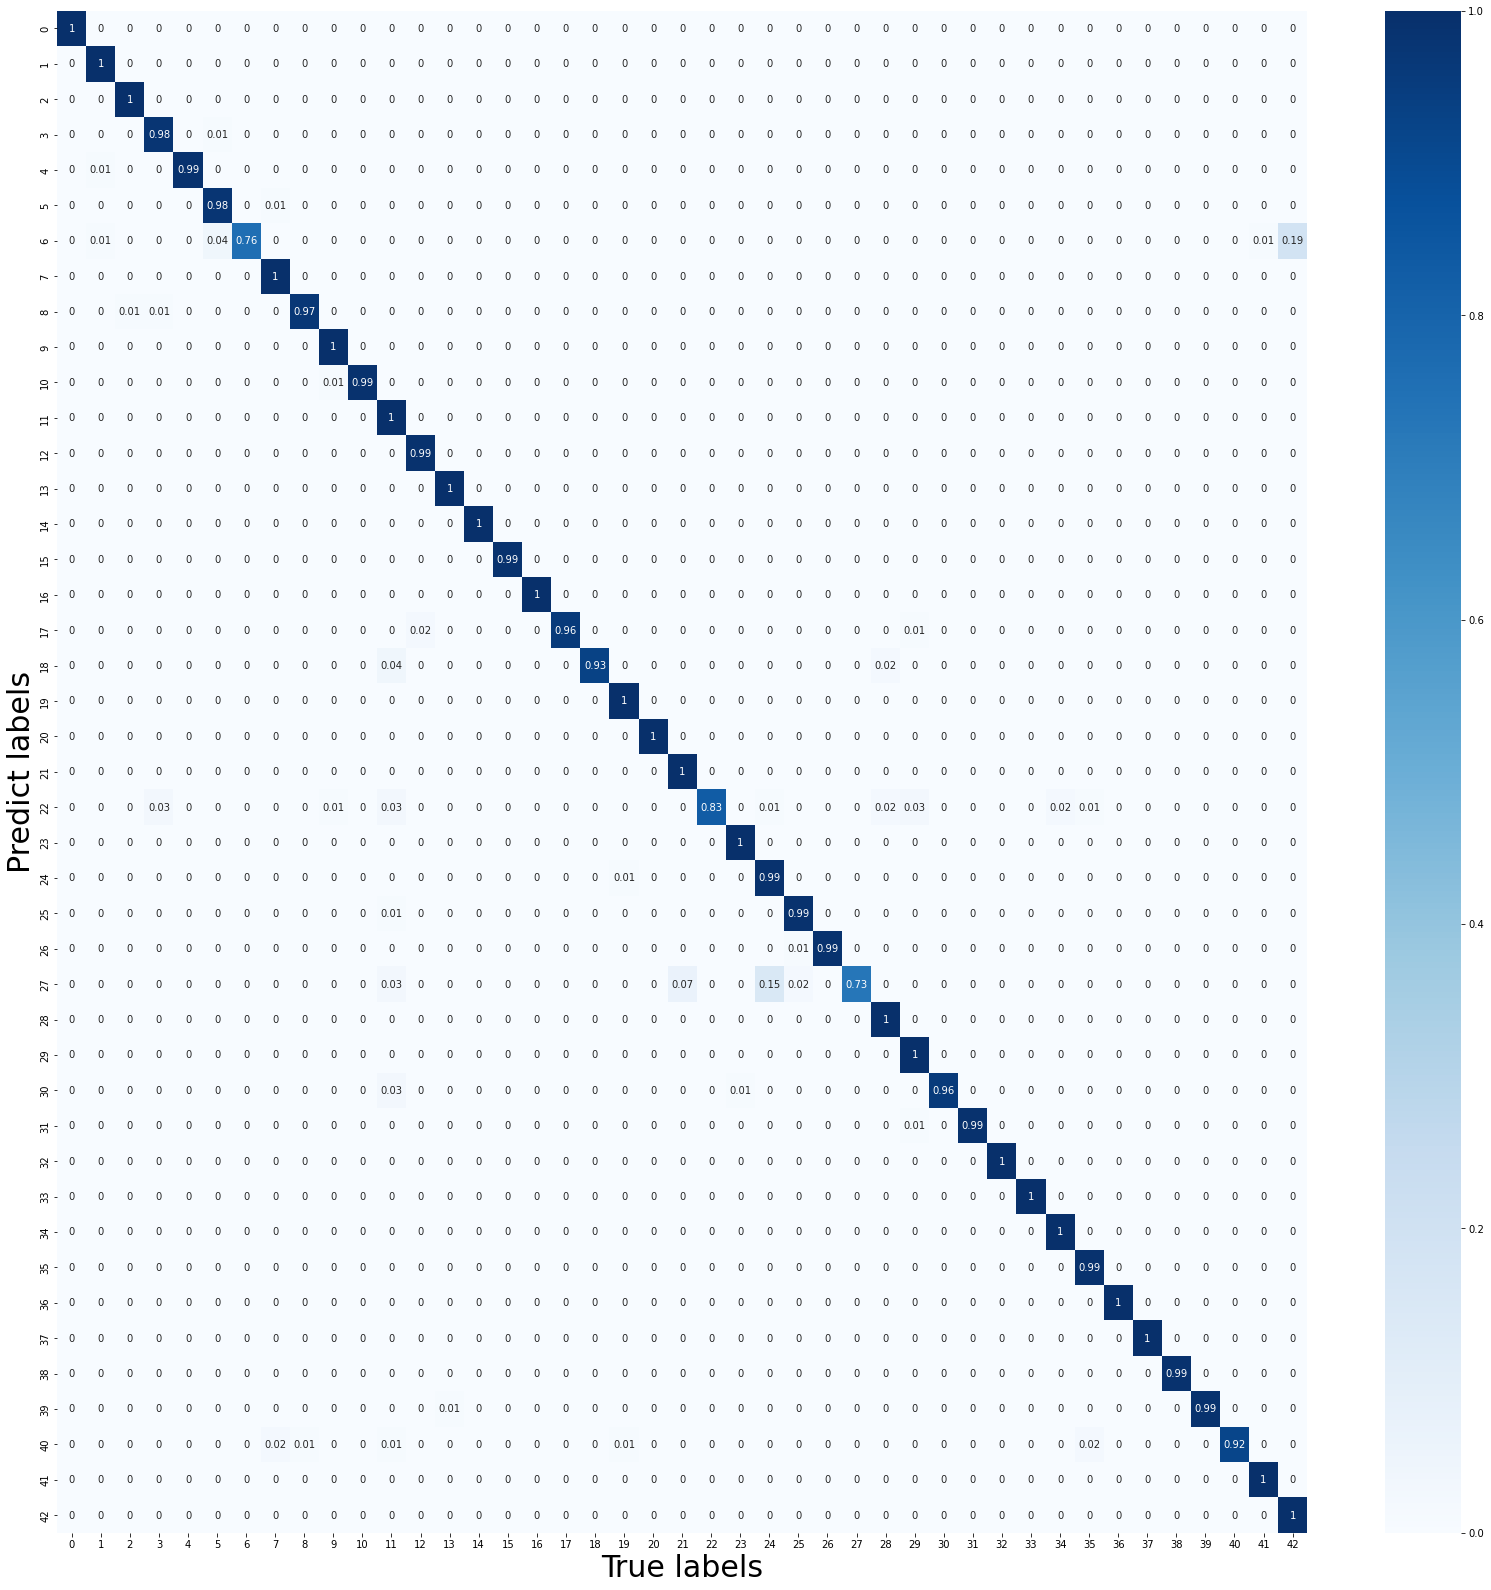

In [25]:
plt.figure(figsize=(28, 28))


sns.heatmap(mat_norm, annot=True, cmap="Blues")
plt.xlabel('True labels', fontsize=30)
plt.ylabel('Predict labels', fontsize=30)
# plt.ylim(0,10)
plt.show()

In [13]:
gpu_INT8_model.evaluate(testDataGenerator, verbose=1)

790/790 [==============================] - 67s 83ms/step - loss: 0.2814 - accuracy: 0.9479

[0.28136664628982544, 0.9479018449783325]

In [45]:
int8_pred = gpu_INT8_model.predict(testDataGenerator)

In [46]:
y_int8 = np.argmax(int8_pred, axis=1)

mat_int8 = confusion_matrix(testDataGenerator.classes, y_int8)
mat_int8_norm = mat_int8.astype('float') / mat_int8.sum(axis=1)[:, np.newaxis]
mat_int8_norm= np.around(mat_int8_norm, decimals=2)

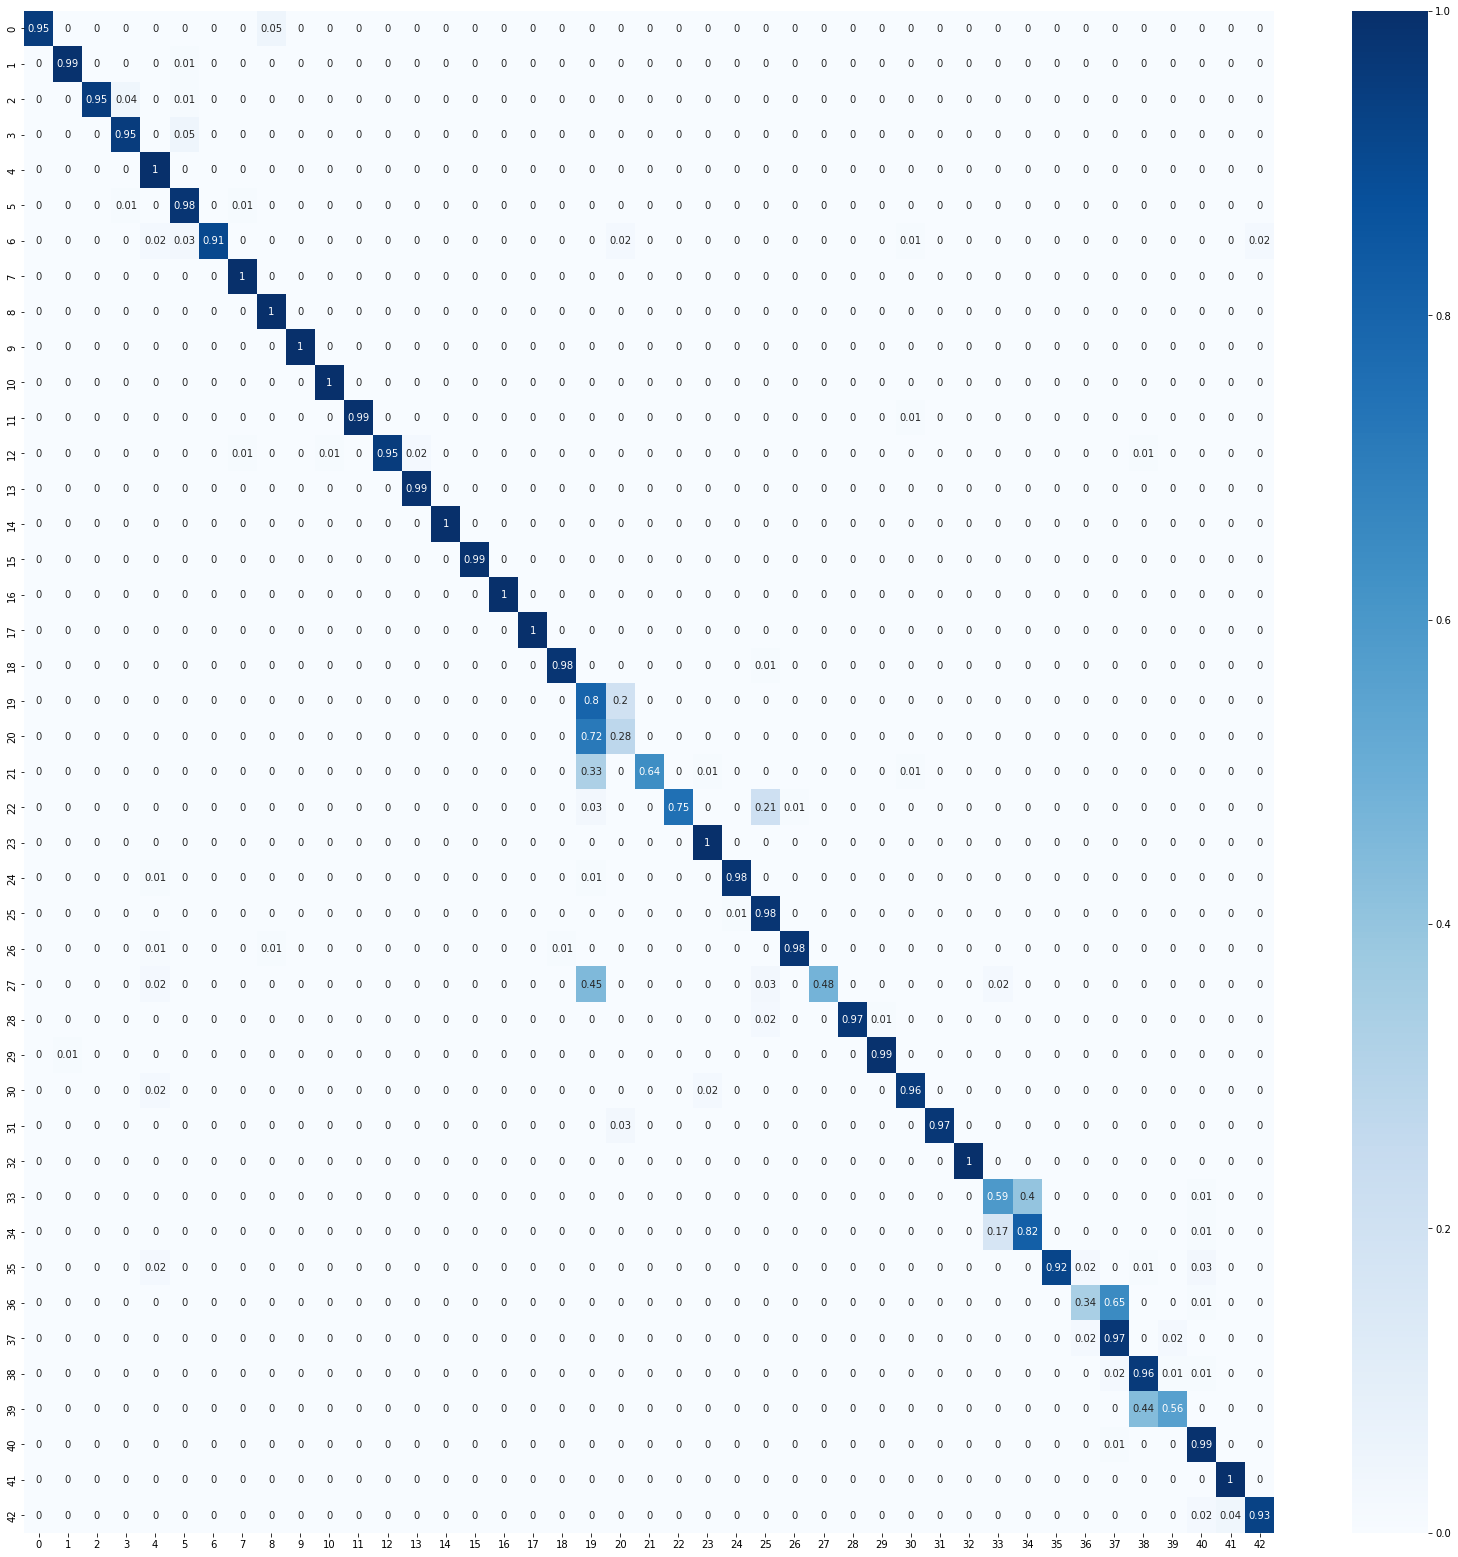

In [47]:
plt.figure(figsize=(28, 28))

sns.heatmap(mat_int8_norm, annot=True, cmap="Blues")

# plt.ylim(0,10)
plt.show()